# Statistical analysis II

This set of notes aims to build upon the first set on statistical analysis. We look at more complicated statistical models as well as further properties of the statistical methods we discussed in the first set.

In [3]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
matplotlib.rc('figure', figsize=(14, 8))

## Autocorrelation and Autoregressive models

An *autoregressive* or $AR(p)$ model is one which is a regression of a time series on its past values (its lags), satisfying the following conditions:
1. The expected value of the time series is constant and finite at all times, i.e. $\mathbb{E}[y_t]=\mu$, $\mu<\infty\;\forall t$
2. The variance of the time series is constant and finite for all time periods.
3. For $\lambda$ constant, $|\lambda|<\infty$, require $\text{cov}(y_t,y_{t-s})=\lambda$, where $t=1,2,...,T$, $s=0,\pm 1,\pm2,...,\pm T$. In other words, the covariance of the time series with itself for a fixed number of periods in either the future or the past is constant and finite for all time periods.

Note that condition (3) implies (2). For example, let $x_t$ be a time series. Then the $AR(1)$ model is
$$
x_t=b_0+b_1x_{t-1}+\epsilon_t
$$
where $\epsilon_t$ is an error term. Thus an $AR(p)$ model takes the form
$$
x_t=b_0+b_1x_{t-1}+b_2x_{t-2} +...+b_px_{t-p}+\epsilon_t\,.
$$

Let us now try to simulate and draw data samples from an $AR(3)$ process.

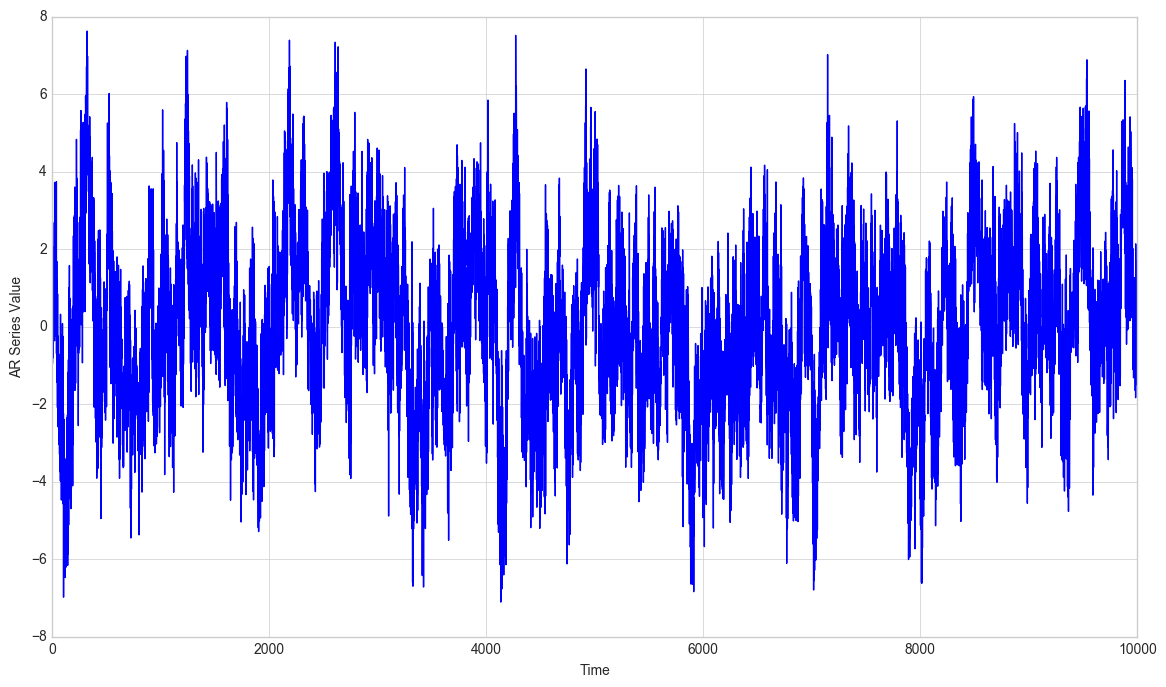

In [4]:
import statsmodels.tsa as tsa

# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05])
X = np.array([1])

mu = 0
sigma = 1

for i in range(10000):
    X = np.append(X, AR(b, X, mu, sigma))
    
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value');

Autoregressive processes will tend to have more extreme values than data drawn from, say, a normal distribution. This is because the value at each time point is influenced by its recent values. If the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as 'fat-tailledness' (fat-tailed distribution) because the extremes on the pdf will be fatter than in a normal distribution.

Tail risk is present in finance due to the fact that tail events do occur, albeit infrequently. There is a difficulty in accounting for them in models and if we suspect that a process is autoregressive, we should expect risk from tail events and adjust accordingly. Note however that tail risk does not only come from AR models.

In [5]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))    
    for k in range(4):             
        #stores tail probabilities of the sample series vs a normal series
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X        
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    print 'Frequency of std events in X \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[0])
    print 'Frequency of std events in a normal process \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[1])
    return A

compare_tails_to_normal(X);

Frequency of std events in X 
1: 0.327567243276	2: 0.185481451855	3: 0.0909909009099	4: 0.035796420358
Frequency of std events in a normal process 
1: 0.158655253931	2: 0.0227501319482	3: 0.00134989803163	4: 3.16712418331e-05


Note that since AR processes are tail heavy and have a non-normal distribution, our usual estimates of variance on them will be wrong. This further affects statistical quantities such as confidence intervals and p-values, which is problematic.

In [6]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    # Compute the 95% c.i. bounds using standard error
    lower = mu - 1.96 * (sigma/np.sqrt(T))
    upper = mu + 1.96 * (sigma/np.sqrt(T))
    return lower, upper

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False
    
def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

trials = 1000
outcomes = np.zeros((trials, 1))

for i in range(trials):
    #note these are the same values we used to generate the initial AR array
    Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 100)
    if check_unadjusted_coverage(Z):
        # The interval contains 0, the true value
        outcomes[i] = 1
    else:
        outcomes[i] = 0
        
np.sum(outcomes) / trials

0.193

This result is vastly less than the expected 0.95. This is due to the AR series fluctuating a lot more, so the confidence intervals are smaller than they should be and do not contain the correct value nearly enough.

One attempt to estimate variance on an AR series is using the *Newey-West estimation*.

How do we identify AR behaviour? In order to determine the order $p$ of an $AR(p)$ model, we look at autocorrelations of the time series. These are correlations of the series with its past values. The $k$th order autocorrelation is
$$
\rho_k=\frac{\text{cov}(x_t,x_{t-k})}{\sigma_x^2}=\frac{\mathbb{E}[(x_t-\mu)(x_{t-k}-\mu)]}{\sigma_x^2}\,,
$$
where $k$ represents the number of periods lagged. We cannot directly observe the autocorrelations so we estimate them as
$$
\hat{\rho}_k=\frac{\sum_{t=k+1}^T[(x_t-\bar{x})(x_{t-k}-\bar{x})]}{\sum_{t=1}^T(x_t-\bar{x})^2}\,.
$$

A pair of tools called the autocorrelation function (ACF) and the partial autocorrelation function (PACF) allows us to do this. The PACF controls for shorter lags. Together, they compute the sample autocorrelations for us, allowing us to determine the value of $p$.

Autocorrelations:
[ 1.          0.57070553  0.58001725  0.88553976  0.55669882  0.57640436
  0.78307405  0.54759415  0.55254723  0.70158722  0.53082572  0.52673077
  0.62850967  0.50091633  0.48541475  0.56544198  0.46391848  0.45390828
  0.51491108  0.43375521  0.43938017  0.46783793  0.40843913  0.42270738
  0.42566802  0.38298857  0.38379558  0.40029717  0.36548704  0.36088258
  0.37743521  0.34745858  0.34065687  0.35239327  0.33194099  0.31758452
  0.33113111  0.31688646  0.2818213   0.31237461  0.31252031]

Partial Autocorrelations:
[ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01

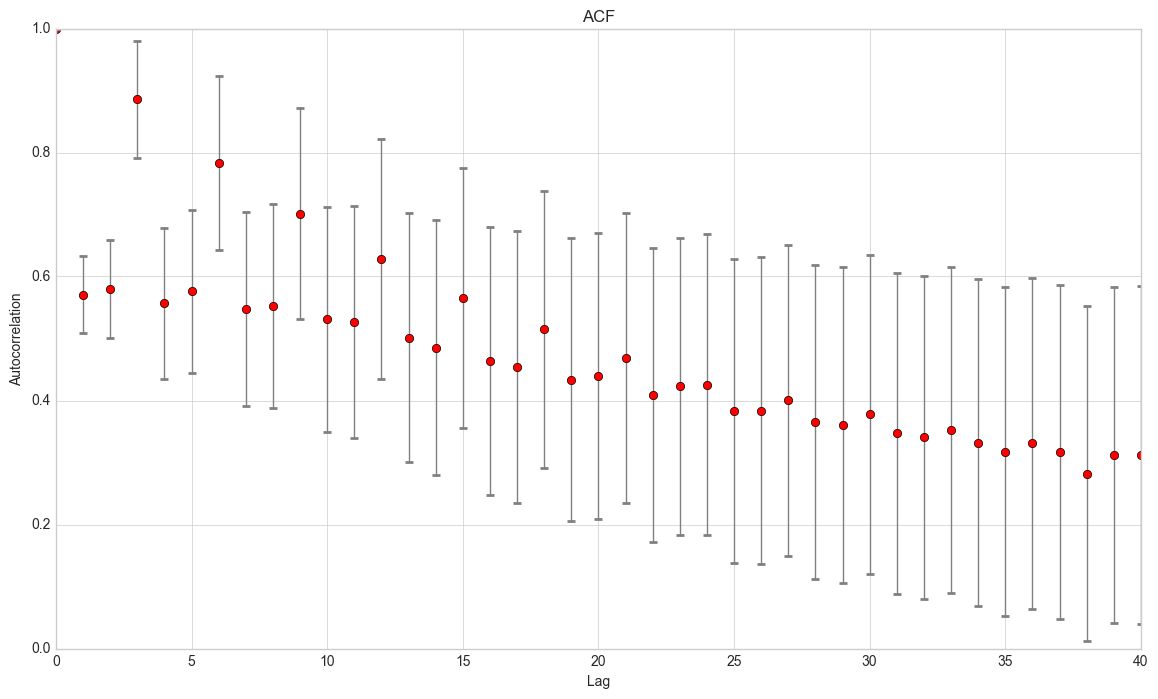

In [7]:
from statsmodels.tsa.stattools import acf, pacf
X = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 1000)
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 40
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].

# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)
print 'Autocorrelations:\n' + str(X_acf) + '\n'
print 'Partial Autocorrelations:\n' + str(X_pacf)

def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)

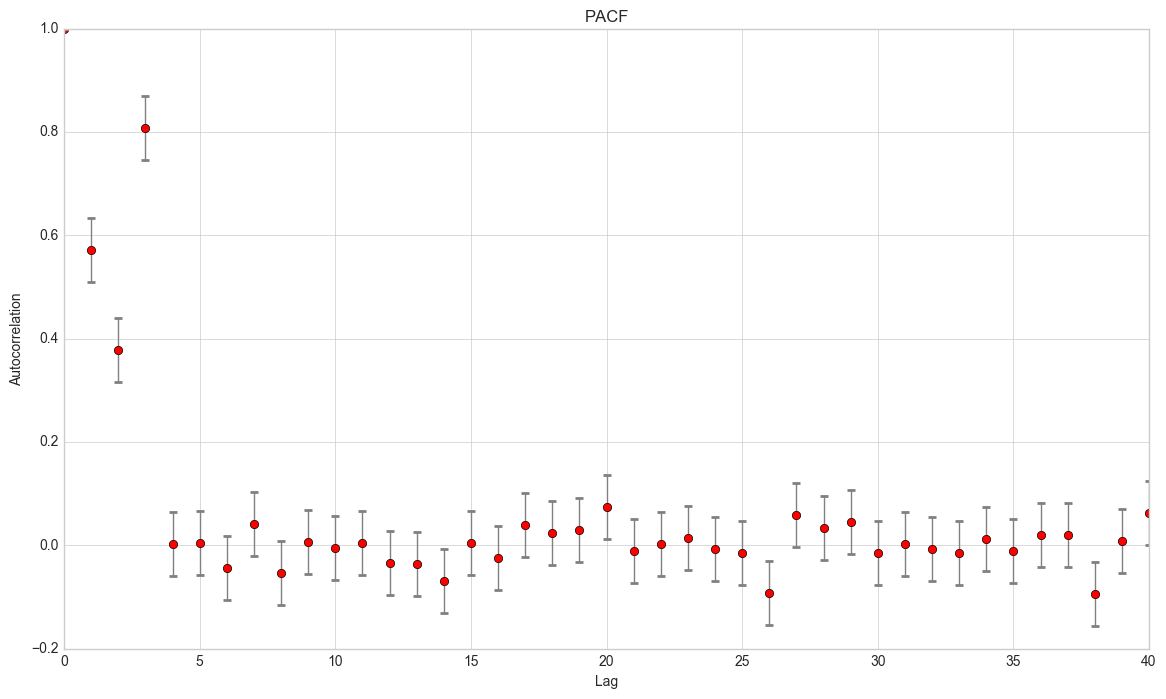

In [8]:
plot_acf(X_pacf, X_pacf_confs, title='PACF')

Notice how for the PACF, only the first three lags are the ones that appear to be significantly different from 0, which makes sense because we directly constructed an AR model of order 3. However, these results may vary for each random series generated in this notebook.

In a real-world time series, we use these plots to determine the order of our model. We then attempt to fit a model using a maximum likelihood function. Let us do this now.

Parameters
[ 0.01001762  0.04631952  0.06669125  0.84444655 -0.02662476  0.07031018
 -0.03883539  0.05362627 -0.06257934  0.03183551  0.02255835  0.06366225
 -0.02663838 -0.00824025 -0.09032174 -0.02259851 -0.05894006 -0.03575162
  0.01899755  0.0265497   0.08158745 -0.00494997]
Standard Error
[ 0.03210283  0.03228516  0.03221285  0.03226938  0.04224386  0.04226218
  0.04228528  0.04223737  0.04222499  0.04230633  0.04232241  0.04227582
  0.04230175  0.04232492  0.04221253  0.04221065  0.04218858  0.04214434
  0.04212185  0.03217742  0.03220652  0.03227438]


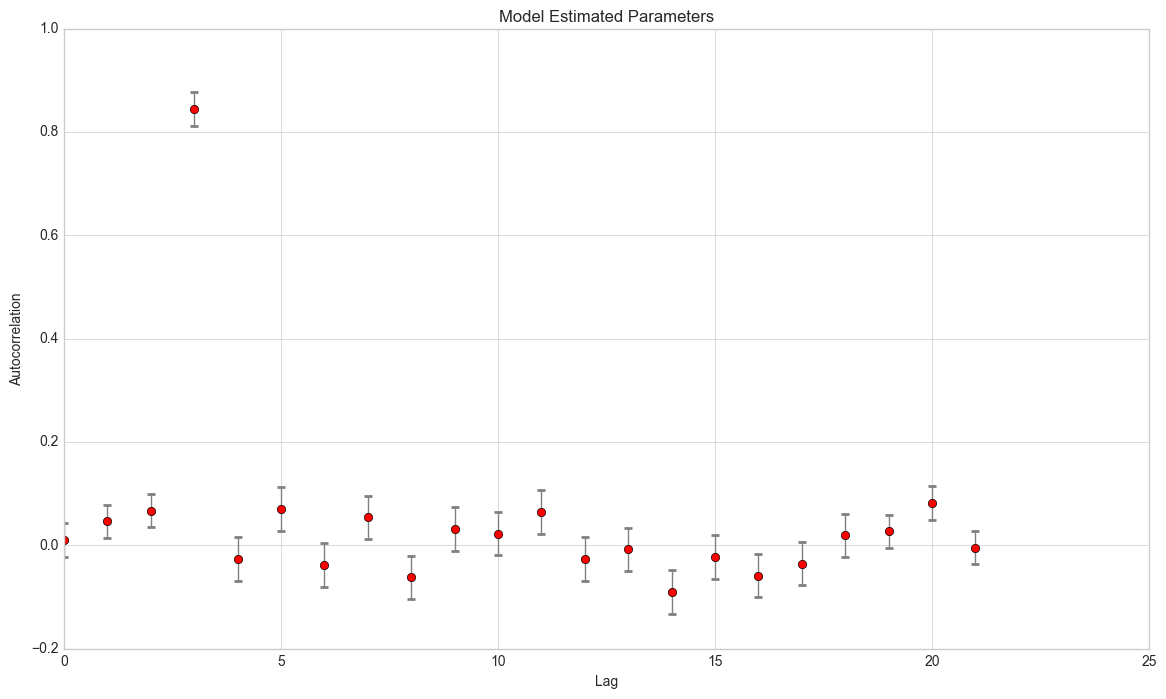

In [9]:
# Construct an unfitted model
model = tsa.api.AR(X)
# Fit it
model = model.fit()

print 'Parameters'
print model.params
print 'Standard Error'
print model.bse

# To plot this we'll need to format a confidence interval 2D array like the previous functions returned
# Here is some quick code to do that
model_confs = np.asarray((model.params - model.bse, model.params + model.bse)).T

plot_acf(model.params, model_confs, title='Model Estimated Parameters')